In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler
from PIL import Image

In [2]:
# Directories
train_dir = 'D:/Permanent/train'
test_dir = 'D:/Permanent/test'

In [3]:
# Load training data
image_paths = []
age_labels = []
gender_labels = []
image_ids = []  # Define an array for image IDs

for filename in os.listdir(train_dir):
    image_path = os.path.join(train_dir, filename)
    temp = filename.split('_')
    image_id = temp[0]  # Extracting image ID
    gender = int(temp[1])
    age = int(temp[2].split()[0])  # Extracting age from filename
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)
    image_ids.append(image_id)  # Store image IDs

# Convert to numpy arrays
image_ids = np.array(image_ids)
train_df = pd.DataFrame({'image': image_paths, 'age': age_labels, 'gender': gender_labels, 'image_id': image_ids})


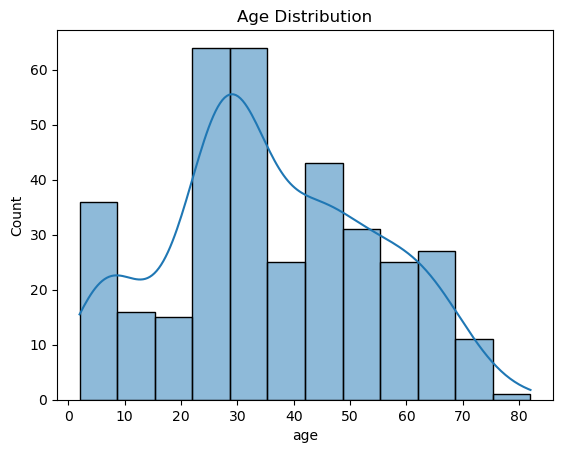

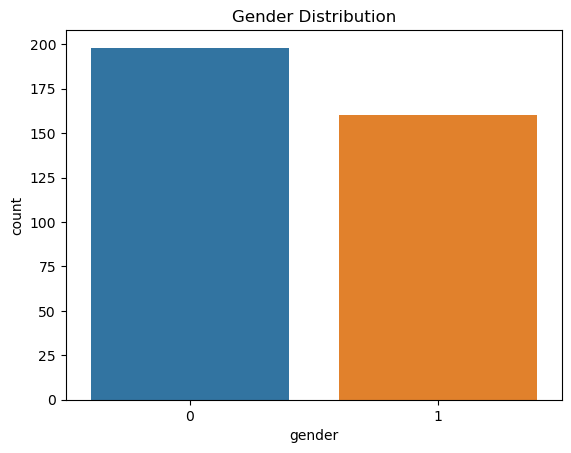

  0%|          | 0/358 [00:00<?, ?it/s]

In [4]:
# Exploratory Data Analysis
sns.histplot(train_df['age'], kde=True)
plt.title("Age Distribution")
plt.show()

sns.countplot(x='gender', data=train_df)
plt.title("Gender Distribution")
plt.show()

# Load Images
def load_images(image_paths, target_size=(224, 224)):
    images = []
    for img_path in tqdm(image_paths):
        img = load_img(img_path, target_size=target_size, color_mode="rgb")
        img = np.array(img) / 255.0
        images.append(img)
    return np.array(images)

X_images = load_images(train_df['image'])
y_gender = np.array(train_df['gender'])
y_age = np.array(train_df['age'])


In [5]:
# Split Train-Validation
X_train, X_val, y_train_gender, y_val_gender, y_train_age, y_val_age = train_test_split(
    X_images, y_gender, y_age, test_size=0.2, stratify=y_gender, random_state=42
)

In [6]:
# Balance classes for Gender Classification
ros = RandomOverSampler()
X_train_gender, y_train_gender_balanced = ros.fit_resample(X_train.reshape(len(X_train), -1), y_train_gender)
X_train_gender = X_train_gender.reshape(-1, 224, 224, 3)

# Balance classes for Age Regression
X_train_age, y_train_age_balanced = ros.fit_resample(X_train.reshape(len(X_train), -1), y_train_age)
X_train_age = X_train_age.reshape(-1, 224, 224, 3)

In [7]:
# Gender Model
def create_gender_model(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    return model

gender_model = create_gender_model()
gender_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train Gender Model
history_gender = gender_model.fit(X_train_gender, y_train_gender_balanced, validation_data=(X_val, y_val_gender),
                                  epochs=20, batch_size=32)


Epoch 1/20
10/10 [==============================] - 24s 2s/step - loss: 0.7755 - accuracy: 0.4810 - val_loss: 0.6924 - val_accuracy: 0.4444
Epoch 2/20
10/10 [==============================] - 23s 2s/step - loss: 0.6834 - accuracy: 0.5665 - val_loss: 0.6841 - val_accuracy: 0.6250
Epoch 3/20
10/10 [==============================] - 23s 2s/step - loss: 0.6686 - accuracy: 0.6076 - val_loss: 0.6612 - val_accuracy: 0.6667
Epoch 4/20
10/10 [==============================] - 23s 2s/step - loss: 0.6442 - accuracy: 0.6329 - val_loss: 0.6442 - val_accuracy: 0.6250
Epoch 5/20
10/10 [==============================] - 23s 2s/step - loss: 0.6154 - accuracy: 0.6930 - val_loss: 0.6220 - val_accuracy: 0.5972
Epoch 6/20
10/10 [==============================] - 21s 2s/step - loss: 0.5949 - accuracy: 0.6994 - val_loss: 0.6058 - val_accuracy: 0.7083
Epoch 7/20
10/10 [==============================] - 21s 2s/step - loss: 0.5495 - accuracy: 0.7278 - val_loss: 0.5962 - val_accuracy: 0.6111
Epoch 8/20
10/10 [==

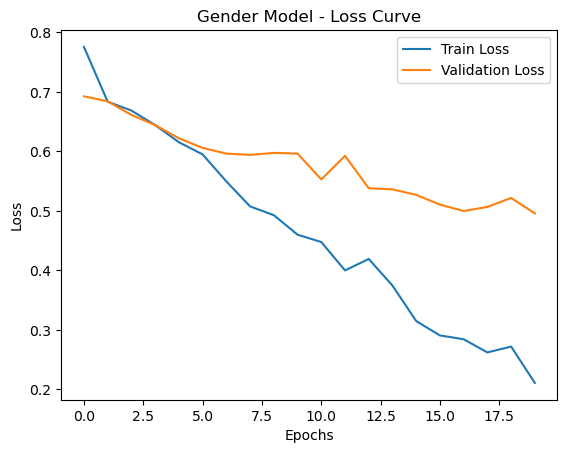

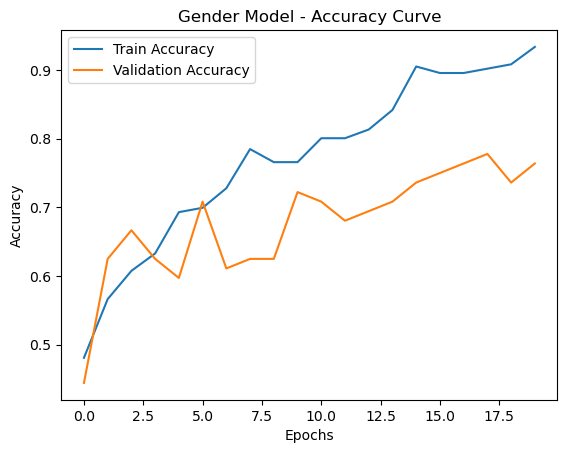

3/3 [==============================] - 1s 306ms/step


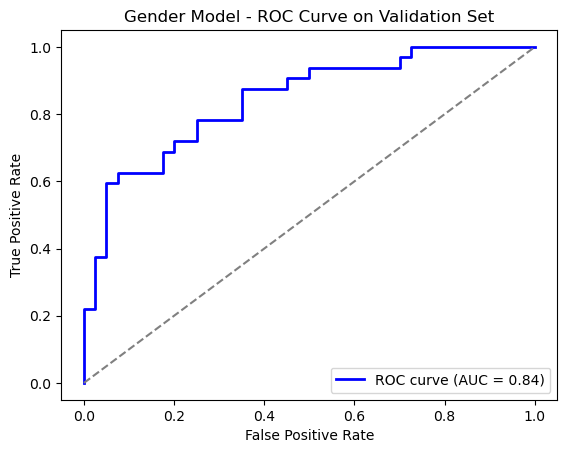

In [8]:
# Plot Gender Model Loss Curve
plt.figure()
plt.plot(history_gender.history['loss'], label='Train Loss')
plt.plot(history_gender.history['val_loss'], label='Validation Loss')
plt.title('Gender Model - Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Gender Model Accuracy Curve
plt.figure()
plt.plot(history_gender.history['accuracy'], label='Train Accuracy')
plt.plot(history_gender.history['val_accuracy'], label='Validation Accuracy')
plt.title('Gender Model - Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Gender Model - ROC Curve on Validation
y_val_gender_pred_prob = gender_model.predict(X_val).ravel()
val_fpr, val_tpr, _ = roc_curve(y_val_gender, y_val_gender_pred_prob)
roc_auc = auc(val_fpr, val_tpr)

plt.figure()
plt.plot(val_fpr, val_tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gender Model - ROC Curve on Validation Set')
plt.legend(loc="lower right")
plt.show()

In [9]:
# Age Model
def create_age_model(input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1)(x)
    model = Model(inputs, output)
    return model

age_model = create_age_model()
age_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

# Train Age Model
history_age = age_model.fit(X_train_age, y_train_age_balanced, validation_data=(X_val, y_val_age),
                            epochs=20, batch_size=32)


Epoch 1/20
31/31 [==============================] - 62s 2s/step - loss: 855.3177 - mae: 23.5762 - val_loss: 358.4253 - val_mae: 15.6463
Epoch 2/20
31/31 [==============================] - 61s 2s/step - loss: 468.2333 - mae: 18.2174 - val_loss: 363.4609 - val_mae: 15.8986
Epoch 3/20
31/31 [==============================] - 60s 2s/step - loss: 431.5886 - mae: 17.4977 - val_loss: 293.9297 - val_mae: 14.2889
Epoch 4/20
31/31 [==============================] - 62s 2s/step - loss: 382.1779 - mae: 16.3441 - val_loss: 242.3337 - val_mae: 12.6467
Epoch 5/20
31/31 [==============================] - 62s 2s/step - loss: 284.7583 - mae: 13.9736 - val_loss: 196.6359 - val_mae: 11.4678
Epoch 6/20
31/31 [==============================] - 62s 2s/step - loss: 230.3524 - mae: 12.1083 - val_loss: 198.1182 - val_mae: 11.3365
Epoch 7/20
31/31 [==============================] - 61s 2s/step - loss: 195.8797 - mae: 10.9112 - val_loss: 173.0991 - val_mae: 9.9841
Epoch 8/20
31/31 [==============================]

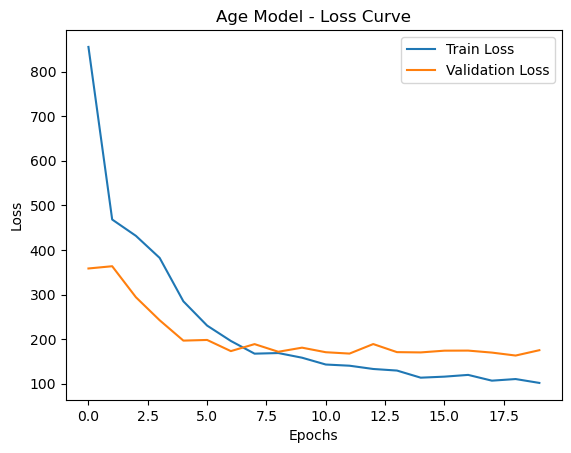

In [10]:
# Plot Age Model Loss Curve
plt.figure()
plt.plot(history_age.history['loss'], label='Train Loss')
plt.plot(history_age.history['val_loss'], label='Validation Loss')
plt.title('Age Model - Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# Load test images
test_image_paths = []
test_age_labels = []
test_gender_labels = []
test_image_ids = []  # Define an array for test image IDs

for filename in os.listdir(test_dir):
    image_path = os.path.join(test_dir, filename)
    temp = filename.split('_')
    image_id = temp[0]  # Extracting image ID
    gender = int(temp[1])
    age = int(temp[2].split()[0])  # Extracting age from filename
    test_image_paths.append(image_path)
    test_age_labels.append(age)
    test_gender_labels.append(gender)
    test_image_ids.append(image_id)  # Store test image IDs

# Convert to numpy arrays
test_image_ids = np.array(test_image_ids)
test_df = pd.DataFrame({'image': test_image_paths, 'age': test_age_labels, 'gender': test_gender_labels, 'image_id': test_image_ids})
X_test_images = load_images(test_df['image'])
y_test_gender = np.array(test_df['gender'])
y_test_age = np.array(test_df['age'])

  0%|          | 0/79 [00:00<?, ?it/s]

3/3 [==============================] - 1s 330ms/step
Gender Test Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85        41
           1       0.84      0.84      0.84        38

    accuracy                           0.85        79
   macro avg       0.85      0.85      0.85        79
weighted avg       0.85      0.85      0.85        79

Confusion Matrix:
 [[35  6]
 [ 6 32]]


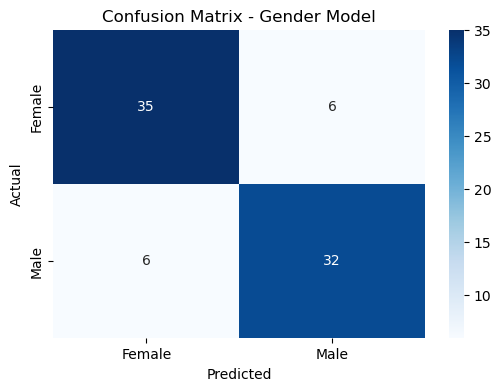

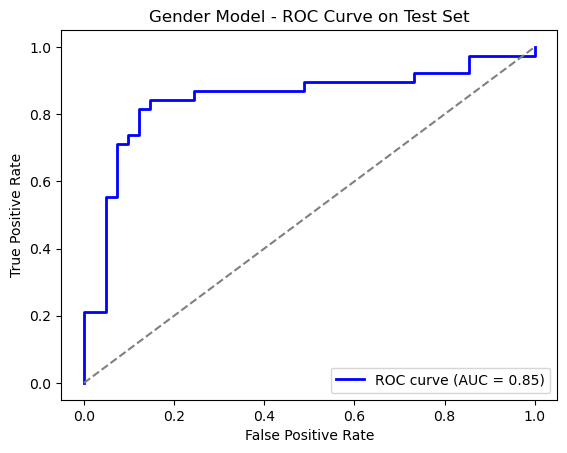

In [12]:
# Gender Model - Test Set Evaluation
y_pred_gender_test_prob = gender_model.predict(X_test_images).ravel()
y_pred_gender_test = (y_pred_gender_test_prob > 0.5).astype(int)

# Calculate ROC Curve
test_fpr, test_tpr, _ = roc_curve(y_test_gender, y_pred_gender_test_prob)
test_roc_auc = auc(test_fpr, test_tpr)

# Print classification report
print("Gender Test Classification Report:\n", classification_report(y_test_gender, y_pred_gender_test))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_gender, y_pred_gender_test)
print("Confusion Matrix:\n", conf_matrix)

# Plotting the Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Gender Model')
plt.show()

# Plot ROC Curve
plt.figure()
plt.plot(test_fpr, test_tpr, color='blue', lw=2, label=f'ROC curve (AUC = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gender Model - ROC Curve on Test Set')
plt.legend(loc="lower right")
plt.show()

In [13]:
# Age Model - Test Set Evaluation
y_pred_age_test = age_model.predict(X_test_images).ravel()

# Evaluation metrics for Age Model
mse_age = mean_squared_error(y_test_age, y_pred_age_test)
mae_age = mean_absolute_error(y_test_age, y_pred_age_test)
rmse_age = np.sqrt(mse_age)  # Calculating RMSE
r2_age = r2_score(y_test_age, y_pred_age_test)

# Calculate MAPE
mape_age = np.mean(np.abs((y_test_age - y_pred_age_test) / y_test_age)) * 100  # MAPE calculation

# Print evaluation results
print(f"Age Model Evaluation:")
print(f"MSE: {mse_age:.2f}")
print(f"MAE: {mae_age:.2f}")
print(f"RMSE: {rmse_age:.2f}")
print(f"R²: {r2_age:.2f}")
print(f"MAPE: {mape_age:.2f}%")

3/3 [==============================] - 1s 301ms/step
Age Model Evaluation:
MSE: 142.88
MAE: 9.30
RMSE: 11.95
R²: 0.29
MAPE: 32.37%
